# Packages


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd
import csv
import sys
import array
import xarray as xr
import cmocean.cm as cmocean
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype=np.float32
#topo_adjust to topo wi
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc

import glob
from glob import glob
import glidertools as gt
import gsw
from scipy.interpolate import griddata
import cmocean
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches


# open dataset

In [2]:
ds_glider = xr.open_dataset('ds_distance.nc')

In [3]:
ds_glider

<xarray.Dataset>
Dimensions:         (ctd_depth: 2001, distance: 544)
Coordinates:
  * ctd_depth       (ctd_depth) float64 0.0 0.5 1.0 1.5 ... 999.0 999.5 1e+03
  * distance        (distance) float64 0.0 1.5 3.0 4.5 ... 811.5 813.0 814.5
    long            (distance) float64 ...
    lat             (distance) float64 ...
    time            (distance) datetime64[ns] ...
Data variables:
    temp            (ctd_depth, distance) float64 ...
    salinity        (ctd_depth, distance) float64 ...
    o2              (ctd_depth, distance) float64 ...
    sol             (ctd_depth, distance) float64 ...
    p               (ctd_depth, distance) float64 ...
    spectral_slope  (ctd_depth, distance) float64 ...
    bp_470_grid_15  (ctd_depth, distance) float64 ...
    bp_700_grid_15  (ctd_depth, distance) float64 ...
Attributes:
    title:          Gridded Dataset in distance relative to current
    description:    Dataset including gridded data in distance and cleaned va...
    author:         Renske Koets
    institution:    Gothenburg University
    creation_date:  2024-10-05
    comment:        This dataset contains temperature, salinity, oxygen, and ...

In [4]:
density_glider = gsw.sigma0(ds_glider.salinity, ds_glider.temp)

In [5]:
AOU_glider = ds_glider.sol - ds_glider.o2

# Transform time to Yearday

In [6]:
ds_glider = xr.open_dataset('ds_distance_alg.nc')

In [7]:
# Convert time to pandas datetime
time_as_datetime = pd.to_datetime(ds_glider.time.values)

# Get the start of the year for each timestamp
start_of_year = pd.to_datetime(time_as_datetime.year.astype(str) + '-01-01')

# Calculate the difference in seconds between the time and the start of the year
time_difference = (time_as_datetime - start_of_year).total_seconds()

# Calculate yearday with decimals
yearday_with_decimals = time_difference / (24 * 60 * 60) + 1

# Add yearday with decimals as a new data variable in ds_glider
ds_glider = ds_glider.assign(year_day=("time", yearday_with_decimals))
ds_glider

<xarray.Dataset>
Dimensions:         (ctd_depth: 2001, distance: 544, time: 544)
Coordinates:
  * ctd_depth       (ctd_depth) float64 0.0 0.5 1.0 1.5 ... 999.0 999.5 1e+03
  * distance        (distance) float64 0.0 1.5 3.0 4.5 ... 811.5 813.0 814.5
    long            (distance) float64 ...
    lat             (distance) float64 ...
    time            (distance) datetime64[ns] 2023-03-22T08:33:43 ... 2023-05...
Data variables:
    temp            (ctd_depth, distance) float64 ...
    salinity        (ctd_depth, distance) float64 ...
    o2              (ctd_depth, distance) float64 ...
    sol             (ctd_depth, distance) float64 ...
    p               (ctd_depth, distance) float64 ...
    spectral_slope  (ctd_depth, distance) float64 ...
    bp_470_grid_15  (ctd_depth, distance) float64 ...
    bp_700_grid_15  (ctd_depth, distance) float64 ...
    chl_15          (ctd_depth, distance) float64 ...
    year_day        (time) float64 81.36 81.5 81.59 81.67 ... 143.5 143.6 143.7
Attributes:
    title:          Gridded Dataset in distance relative to current
    description:    Dataset including gridded data in distance and cleaned va...
    author:         Renske Koets
    institution:    Gothenburg University
    creation_date:  2025-01-22
    comment:        This dataset contains temperature, salinity, oxygen, and ...

# mixed layer depth


In [8]:
import numpy as np
import xarray as xr
import gsw

mixed_layer_densities = []

for i in range(len(ds_glider.distance)):
    # Calculate density for the current ATD point
    density = gsw.sigma0(ds_glider.salinity.isel(distance=i), ds_glider.temp.isel(distance=i)).expand_dims(distance=ds_glider.distance)
    
    # Select reference depth based on the value of ATD
    if ds_glider.distance.isel(distance=i).item() == 0:
        reference_depth = 13
    else:
        reference_depth = 10
    
    # Calculate the reference density at the chosen reference depth
    reference_density = density.sel(ctd_depth=reference_depth)
    density_difference = density - reference_density
    
    # Find the index where the difference is greater than the threshold for the first time
    mixed_layer_index_flat = np.argmax((density_difference > 0.03).values)
    
    # Get the depth index where the difference is greater than the threshold for the first time
    mixed_layer_index = mixed_layer_index_flat.item()
    
    # Get the density value at that depth for the current ATD point
    mixed_layer_density = density.isel(ctd_depth=mixed_layer_index, distance=i)
    
    # Append the mixed layer density directly to the list
    mixed_layer_densities.append(mixed_layer_density)

# Concatenate the list of mixed layer densities along the ATD dimension
mixed_layer_densities = xr.concat(mixed_layer_densities, dim=ds_glider.distance)

#mixed_layer_densities


In [9]:
# NaN zero values
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0.0, np.nan)
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0., np.nan)

In [10]:
MLD = mixed_layer_densities.ctd_depth

 # Combined figure backscatter and  T, S, Oxygen, AOU, Spectral slope, POC

In [12]:
# Replace NaN values with zero in the ds_glider.year_day DataArray
ds_glider['year_day'] = ds_glider['year_day'].fillna(0)

C:\Users\rensk\AppData\Local\Temp\ipykernel_32380\3506382944.py:148: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


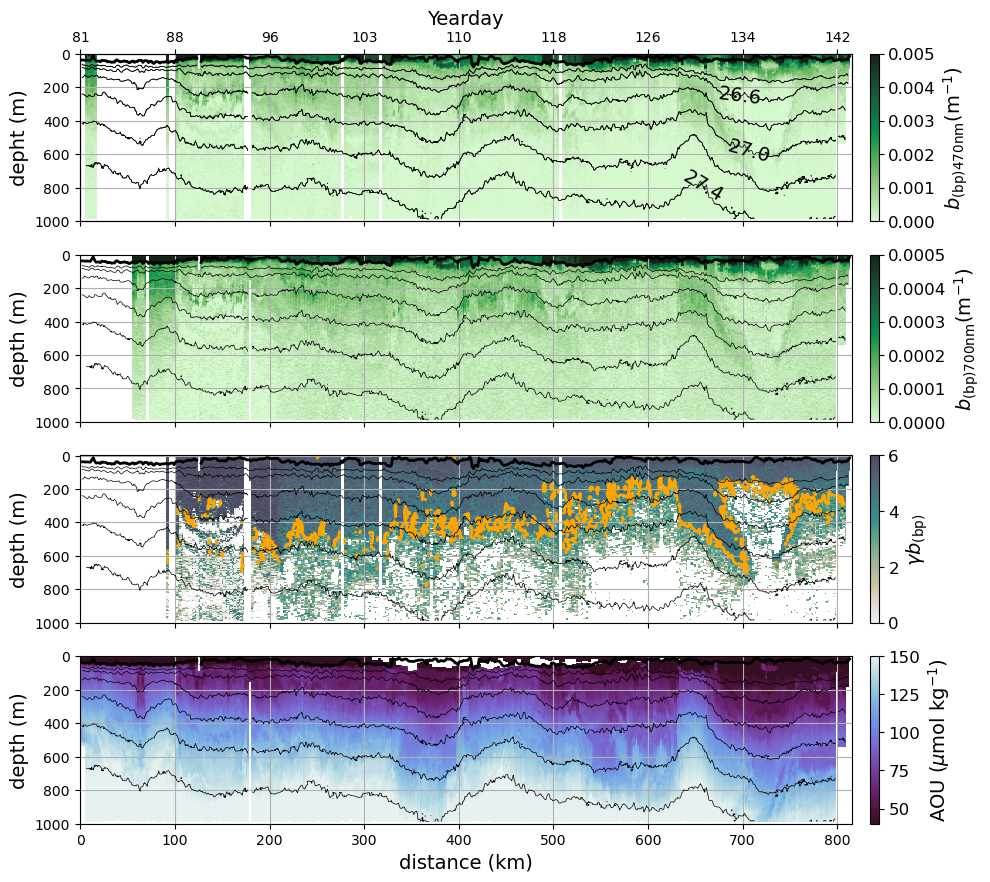

In [42]:
fig, ax = plt.subplots(4, figsize=(12, 10), sharex=True)


density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
AOU = ds_glider.sol - ds_glider.o2

# Create the bar chart

img0 = ax[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.bp_470_grid_15, cmap = cmo.algae, vmax=0.005)
img1 = ax[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.bp_700_grid_15, cmap = cmo.algae, vmax=0.0005)
img2 = ax[2].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.spectral_slope,vmin=0, vmax=6, cmap=cmo.rain, alpha= 0.8)
img3 = ax[3].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, AOU,cmap=cmo.dense_r,  vmin = 40, vmax = 150)



# Copy the original spectral_slope data
original_spectral_slope = ds_glider.spectral_slope.copy()



# Apply Gaussian smoothing to the entire dataset with sigma=[40, 0]
smoothed_spectral_slope = gaussian_filter(original_spectral_slope, sigma=[20, 0])

# Find the indices where the distance is between 680 and 760, and ctd_depth is less than 300
distance_mask = (ds_glider.distance >= 680) & (ds_glider.distance <= 760)
depth_mask = ds_glider.ctd_depth < 300

# Use np.ix_ to create a combined mask for both dimensions
combined_mask = np.ix_(depth_mask, distance_mask)

# Apply Gaussian smoothing with sigma=[5, 0] only to the region 680 to 760 and depth < 300
smoothed_region = gaussian_filter(original_spectral_slope, sigma=[5, 0])

# Replace the values in the specified region with the new smoothing
smoothed_spectral_slope[combined_mask] = smoothed_region[combined_mask]



# Optionally, add a specific contour at level 4
contour_level_4 = ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, smoothed_spectral_slope, levels=[4], colors='orange', linewidths=2)






[a.invert_yaxis() for a in ax]
# Add colorbars to the plots
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label(r'$b_{\mathrm{(bp)470nm}}$(m$^{-1}$)', fontsize=14)
cbar0.ax.tick_params(labelsize=12)

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label(r'$b_{\mathrm{(bp)700nm}}$(m$^{-1}$)', fontsize=14)
cbar1.ax.tick_params(labelsize=12)

cbar2 = plt.colorbar(img2, ax=ax[2], pad=0.02)
cbar2.set_label(r'$\gamma$$b_{\mathrm{(bp)}}$', fontsize=14)
cbar2.ax.tick_params(labelsize=12)

cbar3 = plt.colorbar(img3, ax=ax[3], pad=0.02)
cbar3.set_label(r'AOU ($\mu$mol kg$^{-1}$)', fontsize=14)
cbar3.ax.tick_params(labelsize=12)

ax[3].set_xlabel('distance (km)')
ax[0].set_ylabel('depht (m)')
ax[1].set_ylabel('depth (m)')
ax[2].set_ylabel('depth (m)')
ax[3].set_ylabel('depth (m)')

# Enable grid for all subplots
for a in ax:
    a.grid()

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)




#ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#ax[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)


#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.6], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.6], colors='b', linestyle='--', linewidths=1)
#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.8], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.8], colors='b', linestyle='--', linewidths=1)

#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.8], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[26.8], colors='b', linestyle='--', linewidths=1)
#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27], colors='b', linestyle='--', linewidths=1)

#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27], colors='b', linestyle='--', linewidths=1)
#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.2], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.2], colors='b', linestyle='--', linewidths=1)

#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.2], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.2], colors='b', linestyle='--', linewidths=1)
#ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.4], colors='b', linestyle='--', linewidths=1)
#ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=[27.4], colors='b', linestyle='--', linewidths=1)



ax[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[3].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)


# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 14})  # Set the default font size

# Set the xlabel on the top
ax0 = ax[0].twiny()
ax0.set_xlabel('Yearday')

tick_positions = np.arange(0, max(ds_glider.distance), 100)
tick_labels = ds_glider.year_day[np.searchsorted(ds_glider.distance, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax[0].get_xlim())
ax0.set_xticks(tick_positions)
ax[3].set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])

ax0.tick_params(axis='x', which='major', labelsize='10')

# Set font sizes for specific elements
for a in ax:
    a.set_title(a.get_title(), fontsize=14)  # Increase title font size
    a.set_xlabel(a.get_xlabel(), fontsize=14)  # Increase x-axis label font size
    a.set_ylabel(a.get_ylabel(), fontsize=14)  # Increase y-axis label font size
    a.tick_params(axis='both', which='major', labelsize=10)  # Increase tick label font size
    
levels = np.arange(26.4, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(26.6, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax[0].clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Draw contour lines for each subplot
for i, a in enumerate(ax):
    cs = a.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
    


# Save the figure
plt.savefig('Combined_backscatter_colorbar.png', bbox_inches='tight', dpi=100)

# Show the plot
plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_4444\2398537043.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


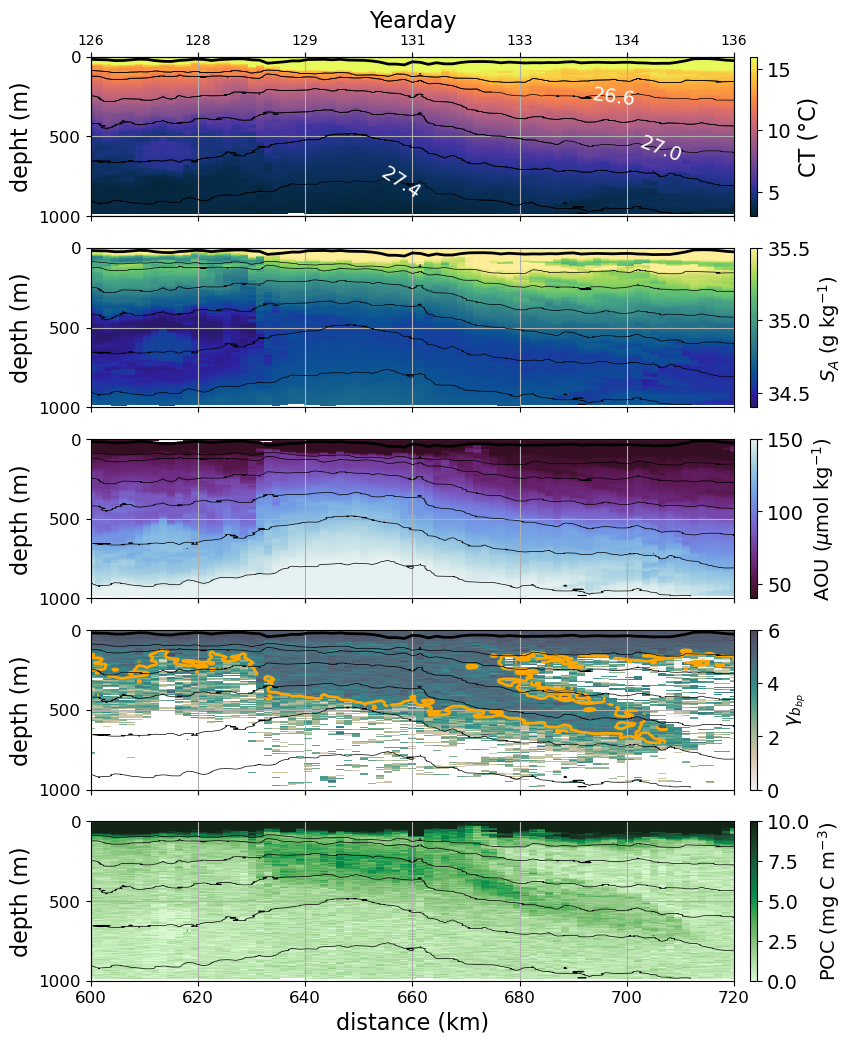

In [13]:
fig, ax = plt.subplots(5, figsize=(10, 12), sharex=True)


density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
AOU = ds_glider.sol - ds_glider.o2

# Apply the conditional multipliers based on ctd_depth
POC = xr.where(
    ds_glider.ctd_depth > MLD,
    ds_glider.bp_700_grid_15 * 31519,
    ds_glider.bp_700_grid_15 * 37537
)

# Assign POC to ds_glider as a new data variable
ds_glider['POC'] = POC

# Create the bar chart

img0 = ax[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.temp, cmap = cmo.thermal, vmin=3, vmax=16)
img1 = ax[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.salinity, cmap = cmo.haline, vmin= 34.4, vmax = 35.5)
img2 = ax[3].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.spectral_slope,vmin=0, vmax=6, cmap=cmo.rain, alpha= 0.8)
img3 = ax[2].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, AOU, cmap=cmo.dense_r,  vmin = 40, vmax = 150)
img4 = ax[4].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.POC, cmap = cmo.algae, vmin=0, vmax=10)

  




# Copy the original spectral_slope data
original_spectral_slope = ds_glider.spectral_slope.copy()



# Apply Gaussian smoothing to the entire dataset with sigma=[40, 0]
smoothed_spectral_slope = gaussian_filter(original_spectral_slope, sigma=[15, 0])

# Find the indices where the distance is between 680 and 760, and ctd_depth is less than 300
distance_mask = (ds_glider.distance >= 680) & (ds_glider.distance <= 760)
depth_mask = ds_glider.ctd_depth < 300

# Use np.ix_ to create a combined mask for both dimensions
combined_mask = np.ix_(depth_mask, distance_mask)

# Apply Gaussian smoothing with sigma=[5, 0] only to the region 680 to 760 and depth < 300
smoothed_region = gaussian_filter(original_spectral_slope, sigma=[5, 0])

# Replace the values in the specified region with the new smoothing
smoothed_spectral_slope[combined_mask] = smoothed_region[combined_mask]



# Optionally, add a specific contour at level 4
contour_level_4 = ax[3].contour(ds_glider.distance, ds_glider.ctd_depth, smoothed_spectral_slope, levels=[4], colors='orange', linewidths=2)


[a.invert_yaxis() for a in ax]
# Add colorbars to the plots
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label('CT (°C)', fontsize=16)
cbar0.ax.tick_params(labelsize=14)

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label('$S_A$ (g kg$^{-1}$)', fontsize=14)
cbar1.ax.tick_params(labelsize=14)

cbar2 = plt.colorbar(img2, ax=ax[3], pad=0.02)
cbar2.set_label(r'$\gamma_{b_{bp}}$', fontsize=14)
cbar2.ax.tick_params(labelsize=14)

cbar3 = plt.colorbar(img3, ax=ax[2], pad=0.02)
cbar3.set_label(r'AOU ($\mu$mol kg$^{-1}$)', fontsize=14)
cbar3.ax.tick_params(labelsize=14)

cbar4 = plt.colorbar(img4, ax=ax[4], pad=0.02)
cbar4.set_label(r'POC (mg C m$^{-3}$)', fontsize=14)
cbar4.ax.tick_params(labelsize=14)

ax[4].set_xlabel('distance (km)')
ax[0].set_ylabel('depht (m)')
ax[1].set_ylabel('depth (m)')
ax[2].set_ylabel('depth (m)')
ax[3].set_ylabel('depth (m)')
ax[4].set_ylabel('depth (m)')

# Enable grid for all subplots
for a in ax:
    a.grid()
# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

ax[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[3].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)

levels = np.arange(26.4, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(26.6, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax[0].clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='white', manual=label_positions)

beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Draw contour lines for each subplot
for i, a in enumerate(ax):
    cs = a.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
    


# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 16})  # Set the default font size


# Set the xlabel on the top
ax0 = ax[0].twiny()
ax0.set_xlabel('Yearday')

tick_positions = np.arange(0, max(ds_glider.distance), 20)
tick_labels = ds_glider.year_day[np.searchsorted(ds_glider.distance, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax[0].get_xlim())
ax0.set_xticks(tick_positions)
ax[4].set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])

ax0.tick_params(axis='x', which='major', labelsize='10')

# Set font sizes for specific elements
for a in ax:
    a.set_title(a.get_title(), fontsize=16)  # Increase title font size
    a.set_xlabel(a.get_xlabel(), fontsize=16)  # Increase x-axis label font size
    a.set_ylabel(a.get_ylabel(), fontsize=16)  # Increase y-axis label font size
    a.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size
    a.set_xlim(600, 720)


# Ensure the top x-axis (Yearday) is consistent
ax0.set_xlim(600, 720)


# Save the figure
plt.savefig('Combined_backscatter_colorbar.png', bbox_inches='tight', dpi=100)


# Show the plot
plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_4444\4017432722.py:47: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


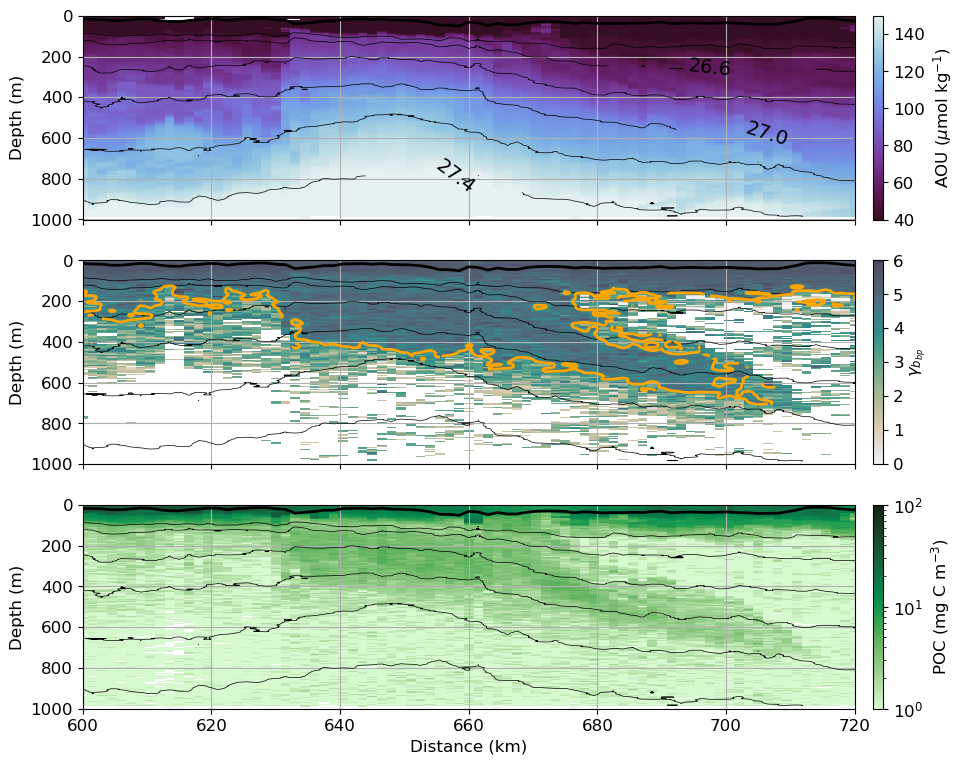

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm



# Assuming necessary data (`ds_glider`, `mixed_layer_densities`, etc.) is already loaded
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Create the figure and subplots (3 panels now)
fig, ax = plt.subplots(3, figsize=(12, 9), sharex=True)

# Define the necessary variables (assuming they are already available)
density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
AOU = ds_glider.sol - ds_glider.o2

# Apply the conditional multipliers based on ctd_depth
POC = xr.where(
    ds_glider.ctd_depth > MLD,
    ds_glider.bp_700_grid_15 * 31519,
    ds_glider.bp_700_grid_15 * 37537
)

# Assign POC to ds_glider as a new data variable
ds_glider['POC'] = POC

# Plot 1: AOU
img1 = ax[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, AOU, cmap=cmocean.cm.dense_r, vmin=40, vmax=150)
ax[0].invert_yaxis()  # Invert y-axis for depth
ax[0].set_ylabel('Depth (m)')


# Plot the Mixed Layer Depth as a black line
ax[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

levels = np.arange(26.4, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(26.6, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax[0].clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

# Apply Gaussian smoothing to the spectral slope
original_spectral_slope = ds_glider.spectral_slope.copy()
smoothed_spectral_slope = gaussian_filter(original_spectral_slope, sigma=[15, 0])

# Specify the region to apply Gaussian smoothing
distance_mask = (ds_glider.distance >= 680) & (ds_glider.distance <= 760)
depth_mask = ds_glider.ctd_depth < 300
combined_mask = np.ix_(depth_mask, distance_mask)
smoothed_region = gaussian_filter(original_spectral_slope, sigma=[5, 0])
smoothed_spectral_slope[combined_mask] = smoothed_region[combined_mask]

beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Plot 2: Spectral Slope
img2 = ax[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.spectral_slope, vmin=0, vmax=6, cmap=cmocean.cm.rain, alpha=0.8)
ax[1].invert_yaxis()  # Invert y-axis for depth
ax[1].set_ylabel('Depth (m)')


# Plot the Mixed Layer Depth as a black line
ax[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add density contours
ax[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Optionally, add a specific contour at level 4 for Spectral Slope
ax[1].contour(ds_glider.distance, ds_glider.ctd_depth, smoothed_spectral_slope, levels=[4], colors='orange', linewidths=2)

# Plot 3: POC with a logarithmic color scale
img3 = ax[2].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.POC, 
                         cmap=cmocean.cm.algae, norm=LogNorm(vmin=1, vmax=100))

ax[2].invert_yaxis()  # Keep depth inverted
ax[2].set_xlabel('Distance (km)')
ax[2].set_ylabel('Depth (m)')

# Adjust colorbar to reflect log scale
cbar3 = plt.colorbar(img3, ax=ax[2], pad=0.02)
cbar3.set_label(r'POC (mg C m$^{-3}$)', fontsize=12)
cbar3.ax.tick_params(labelsize=12)


# Plot the Mixed Layer Depth as a black line
ax[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add density contours
ax[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Add colorbars
cbar1 = plt.colorbar(img1, ax=ax[0], pad=0.02)
cbar1.set_label(r'AOU ($\mu$mol kg$^{-1}$)', fontsize=12)
cbar1.ax.tick_params(labelsize=12)

cbar2 = plt.colorbar(img2, ax=ax[1], pad=0.02)
cbar2.set_label(r'$\gamma_{b_{bp}}$', fontsize=12)
cbar2.ax.tick_params(labelsize=12)



# Enable grid for all subplots
for a in ax:
    a.grid()

# Set x limits
ax[0].set_xlim(600, 720)
ax[1].set_xlim(600, 720)
ax[2].set_xlim(600, 720)

# Set the font sizes for all labels and titles
plt.rcParams.update({'font.size': 12})

# Save and show the figure
plt.savefig('Combined_AOU_Spectral_Slope_POC_with_contours.png', bbox_inches='tight', dpi=100)
plt.show()


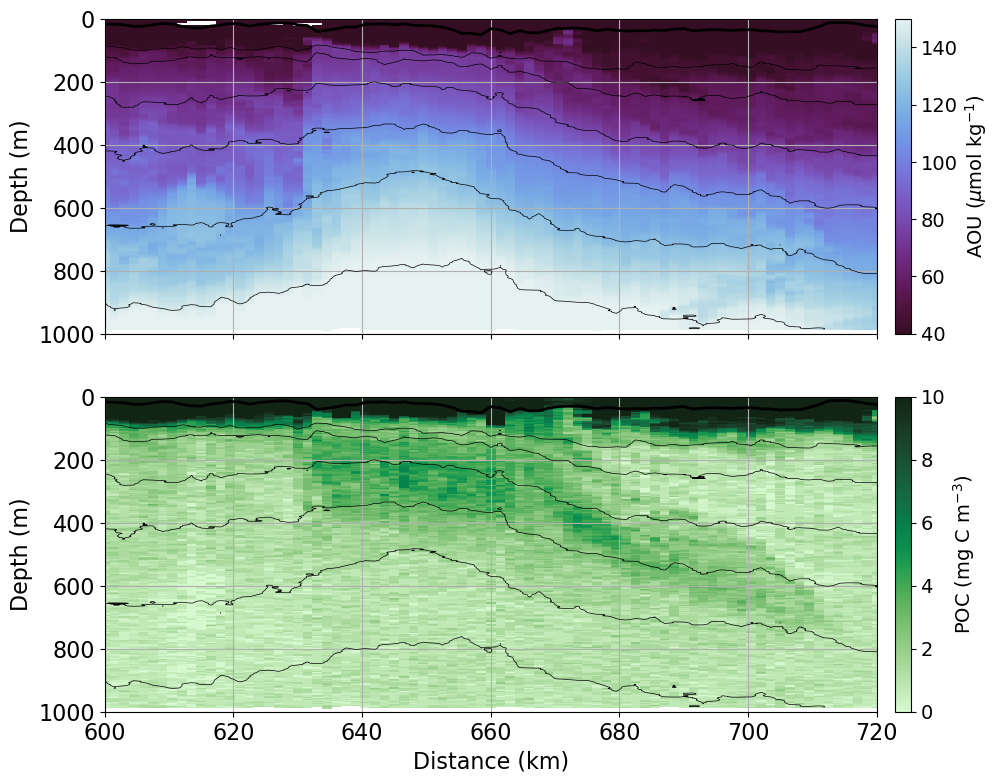

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from scipy.ndimage import gaussian_filter

# Assuming necessary data (`ds_glider`, `mixed_layer_densities`, etc.) is already loaded
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Create the figure and subplots (2 panels now)
fig, ax = plt.subplots(2, figsize=(12, 9), sharex=True)

# Define the necessary variables (assuming they are already available)
density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
AOU = ds_glider.sol - ds_glider.o2

# Apply the conditional multipliers based on ctd_depth
POC = xr.where(
    ds_glider.ctd_depth > MLD,
    ds_glider.bp_700_grid_15 * 31519,
    ds_glider.bp_700_grid_15 * 37537
)

# Assign POC to ds_glider as a new data variable
ds_glider['POC'] = POC

# Plot 1: AOU
img1 = ax[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, AOU, cmap=cmocean.cm.dense_r, vmin=40, vmax=150)
ax[0].invert_yaxis()  # Invert y-axis for depth
ax[0].set_ylabel('Depth (m)')

# Plot the Mixed Layer Depth as a black line
ax[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add density contours
ax[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Plot 2: POC
img2 = ax[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.POC, cmap=cmocean.cm.algae, vmin=0, vmax=10)
ax[1].invert_yaxis()
ax[1].set_xlabel('Distance (km)')
ax[1].set_ylabel('Depth (m)')


# Plot the Mixed Layer Depth as a black line
ax[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add density contours
ax[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Add colorbars
cbar1 = plt.colorbar(img1, ax=ax[0], pad=0.02)
cbar1.set_label(r'AOU ($\mu$mol kg$^{-1}$)', fontsize=14)
cbar1.ax.tick_params(labelsize=14)

cbar2 = plt.colorbar(img2, ax=ax[1], pad=0.02)
cbar2.set_label(r'POC (mg C m$^{-3}$)', fontsize=14)
cbar2.ax.tick_params(labelsize=14)

# Enable grid for both subplots
for a in ax:
    a.grid()

# Set x limits
ax[0].set_xlim(600, 720)
ax[1].set_xlim(600, 720)

# Set the font sizes for all labels and titles
plt.rcParams.update({'font.size': 16})

# Save and show the figure
plt.savefig('AOU_POC_with_contours.png', bbox_inches='tight', dpi=100)
plt.show()


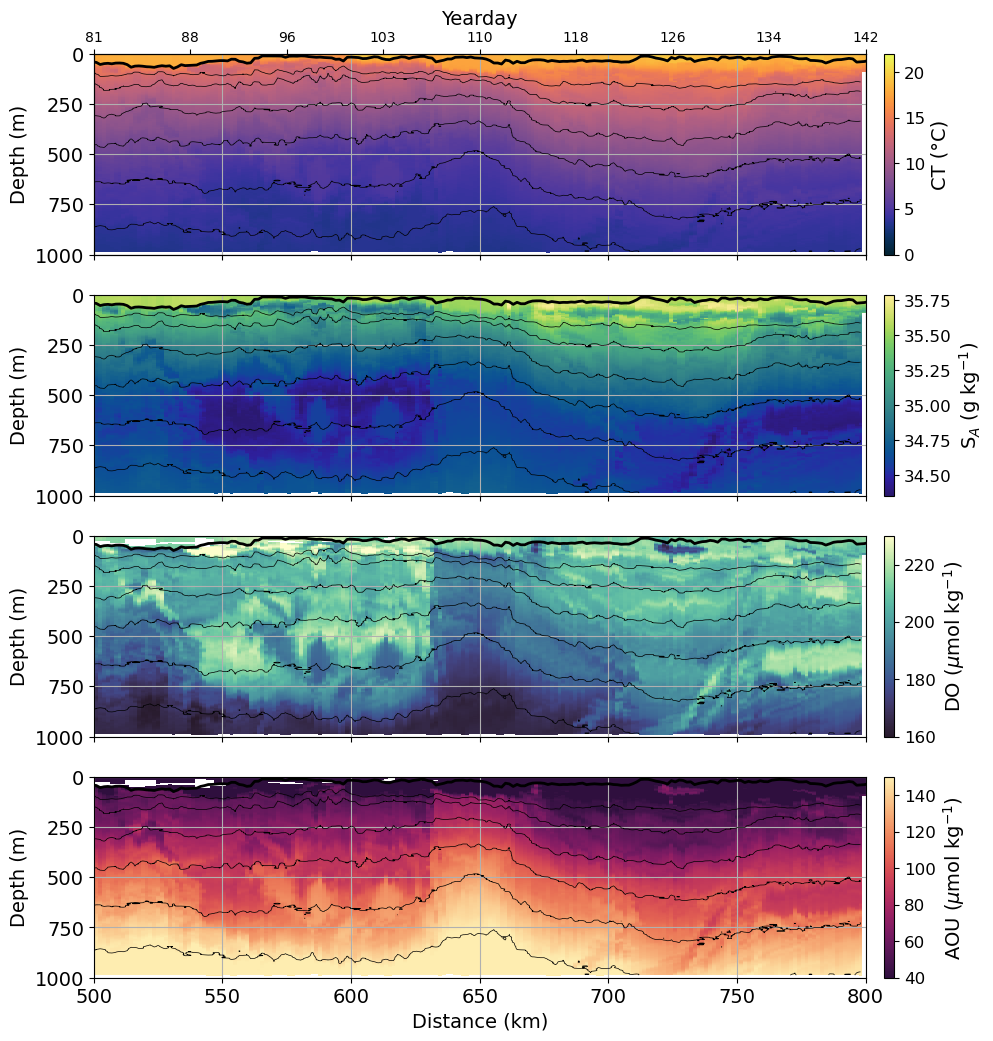

In [141]:
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cmo  # Make sure to import cmocean if you use its colormaps
import gsw  # Ensure you have the gsw library for the density calculations

# Create figure and axes for 4 subplots
fig, ax = plt.subplots(4, figsize=(12, 12), sharex=True)

# Define parameters for colormaps
vmin = 160
vmax = 230

# Calculate density and AOU from the provided datasets
density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
AOU = ds_glider.sol - ds_glider.o2

# Create the bar charts for each subplot
img0 = ax[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.temp, cmap=cmo.thermal, vmin=0, vmax=22)
img1 = ax[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.salinity, cmap=cmo.haline)
img2 = ax[2].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, ds_glider.o2, cmap=cmo.deep_r, vmin=vmin, vmax=vmax)
img3 = ax[3].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, AOU, cmap=cmo.matter_r, vmin=40, vmax=150)

# Invert y-axis for all plots
[a.invert_yaxis() for a in ax]

# Add colorbars to the plots with increased label and tick sizes
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label('CT (°C)', fontsize=14)
cbar0.ax.tick_params(labelsize=12)

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label('S$_{A}$ (g kg$^{-1}$)', fontsize=14)
cbar1.ax.tick_params(labelsize=12)

cbar2 = plt.colorbar(img2, ax=ax[2], pad=0.02)
cbar2.set_label(r'DO ($\mu$mol kg$^{-1}$)', fontsize=14)
cbar2.ax.tick_params(labelsize=12)

cbar3 = plt.colorbar(img3, ax=ax[3], pad=0.02)
cbar3.set_label(r'AOU ($\mu$mol kg$^{-1}$)', fontsize=14)
cbar3.ax.tick_params(labelsize=12)

# Set labels for the x and y axes
ax[3].set_xlabel('Distance (km)')
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlim(500,800)

# Enable grid for all subplots
for a in ax:
    a.grid()

# Generate levels for the contour lines
beginning = 26.4
ending = 27.8
spacing = 0.2
levels = np.arange(beginning, ending + spacing, spacing)

# Draw contour lines for each subplot
for a in ax:
    a.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Plot mixed layer densities
for a in ax:
    a.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 14})

# Set the xlabel on the top axis
ax0 = ax[0].twiny()
ax0.set_xlabel('Yearday')

# Set tick positions and labels for the top x-axis
tick_positions = np.arange(0, max(ds_glider.distance), 100)
tick_labels = ds_glider.year_day[np.searchsorted(ds_glider.distance, tick_positions)].astype(int)
ax0.set_xlim(ax[0].get_xlim())
ax0.set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])
ax0.tick_params(axis='x', which='major', labelsize='10')



# Save the figure
plt.savefig('Combined_glider_speed_with_time_based_colorbar.png', bbox_inches='tight', dpi=100)

# Show the plot
plt.show()


# scatter plot AOU against glider track

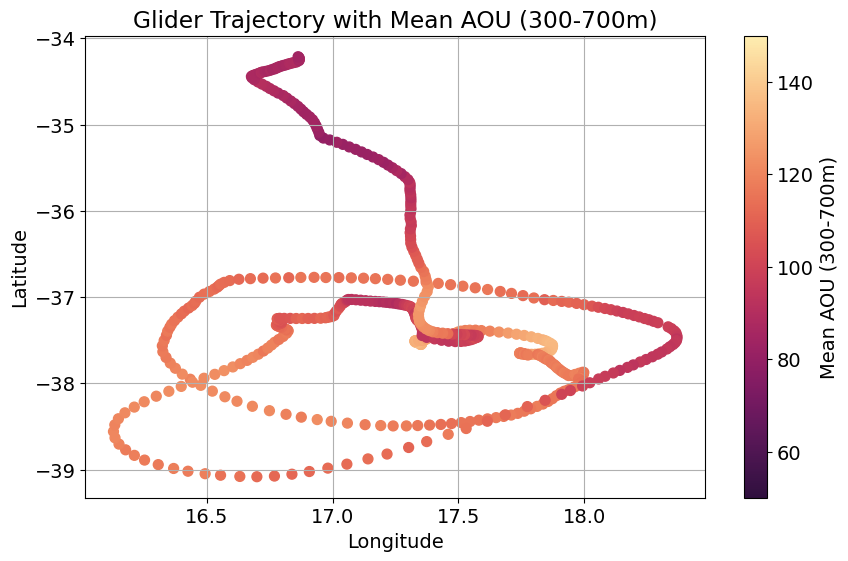

In [91]:
ds_glider['AOU'] = ds_glider.sol - ds_glider.o2

# Step 2: Calculate the mean AOU between 300m and 700m
depth_range = (ds_glider.ctd_depth >= 300) & (ds_glider.ctd_depth <= 700)
mean_AOU = ds_glider.AOU.where(depth_range, drop=True).mean(dim='ctd_depth')

# Step 3: Ensure the mean_AOU and filtered coordinates are aligned in time
#mean_AOU_filtered = mean_AOU.sel(time=lon_filtered.time)

# Step 4: Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(ds_glider.long, ds_glider.lat, c=mean_AOU, cmap = cmo.matter_r, vmin = 50, vmax = 150, s=50)
plt.colorbar(scatter, label='Mean AOU (300-700m)')
plt.title('Glider Trajectory with Mean AOU (300-700m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

# POC

In [110]:
import xarray as xr

# Assuming ds_glider is your dataset and MLD is defined
# Replace MLD with a specific value or an array if it varies across distance

# Apply the conditional multipliers based on ctd_depth
POC = xr.where(
    ds_glider.ctd_depth > MLD,
    ds_glider.bp_700_grid_15 * 31519,
    ds_glider.bp_700_grid_15 * 37537
)

# Assign POC to ds_glider as a new data variable
ds_glider['POC'] = POC

(600.0, 720.0)

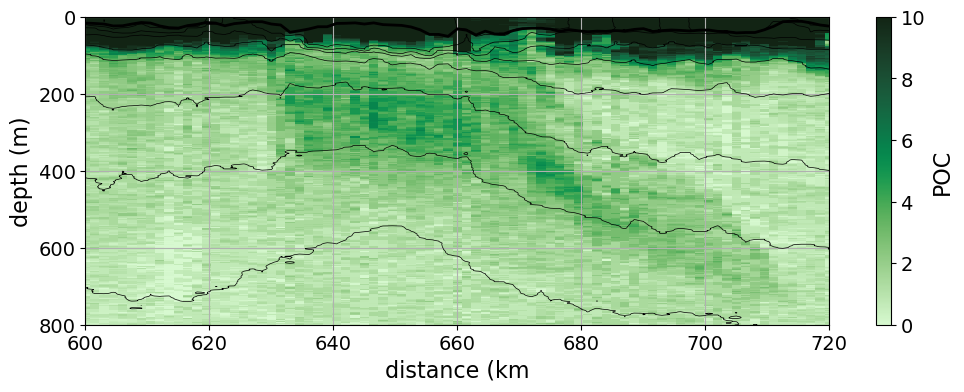

In [237]:
plt.figure(figsize=(12,4))
plt.pcolormesh(POC.distance,POC.ctd_depth,POC,vmin=0,vmax=10,cmap=cmo.algae)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.ylim(0,1000)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('POC')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=15, colors='k', linewidths=0.5)
plt.xlim(600,720)


In [ ]:
ds_work['POC'] = POC


# density grid

In [78]:
ds_work= ds_glider
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
delta_rho = np.diff(density)
np.shape(delta_rho)
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
den_grid_002 = np.arange(np.min(density), np.max(density)+0.002, 0.002)

def grid_to_den(density, var, den_grid):
    
    var_grid = np.ndarray([var.distance.size, den_grid.size])
    
    for v in range(var.distance.size):
        
        density_profile = density.isel(distance=v)
        var_profile = var.isel(distance=v)
    
        ind_sort = np.argsort(density_profile.data)
        den_sort = np.sort(density_profile.data)

        var_grid[v] = griddata(den_sort, var_profile[ind_sort], den_grid)
        
    return var_grid
ox_sol = gsw.O2sol(ds_work.salinity, ds_work.temp, ds_work.p, ds_work.long, ds_work.lat)
temp_den_grid_002 = grid_to_den(density, ds_work.temp, den_grid_002)
sal_den_grid_002 = grid_to_den(density, ds_work.salinity, den_grid_002)
ox_den_grid_002 = grid_to_den(density, ds_work.o2, den_grid_002)
sol_den_grid_002 = grid_to_den(density, ox_sol, den_grid_002)
backscatter_den_grid_002 = grid_to_den(density, ds_work.spectral_slope, den_grid_002)
POC_den_grid_002 = grid_to_den(density, ds_work.POC , den_grid_002)
alg_den_grid_002 = grid_to_den(density, ds_work.chl_15 , den_grid_002)


# Create a Dataset with dimensions ctd_depth and ATD
ds_den = xr.Dataset(
    {'temp': (['density', 'distance'], temp_den_grid_002.T),
     'salinity': (['density', 'distance'], sal_den_grid_002.T),
     'o2': (['density', 'distance'], ox_den_grid_002.T),
     'sol': (['density', 'distance'], sol_den_grid_002.T),
     'spectral_slope': (['density', 'distance'], backscatter_den_grid_002.T),
     'POC': (['density', 'distance'], POC_den_grid_002.T),
     'chl': (['density', 'distance'], alg_den_grid_002.T)},
    coords={'density': den_grid_002,
            'distance': ds_work.distance,}
)

# Add attributes to the dataset
ds_den.attrs['description'] = 'dataset including gridded data in density and distance with cleaned variables'


ds_den

<xarray.Dataset>
Dimensions:         (density: 1605, distance: 544)
Coordinates:
  * density         (density) float64 24.39 24.39 24.39 ... 27.59 27.59 27.6
  * distance        (distance) float64 0.0 1.5 3.0 4.5 ... 811.5 813.0 814.5
Data variables:
    temp            (density, distance) float64 nan nan nan nan ... nan nan nan
    salinity        (density, distance) float64 nan nan nan nan ... nan nan nan
    o2              (density, distance) float64 nan nan nan nan ... nan nan nan
    sol             (density, distance) float64 nan nan nan nan ... nan nan nan
    spectral_slope  (density, distance) float64 nan nan nan nan ... nan nan nan
    POC             (density, distance) float64 nan nan nan nan ... nan nan nan
    chl             (density, distance) float64 nan nan nan nan ... nan nan nan
Attributes:
    description:  dataset including gridded data in density and distance with...

In [79]:
ds_den['AOU'] = ds_den.sol - ds_den.o2
ds_den

<xarray.Dataset>
Dimensions:         (density: 1605, distance: 544)
Coordinates:
  * density         (density) float64 24.39 24.39 24.39 ... 27.59 27.59 27.6
  * distance        (distance) float64 0.0 1.5 3.0 4.5 ... 811.5 813.0 814.5
Data variables:
    temp            (density, distance) float64 nan nan nan nan ... nan nan nan
    salinity        (density, distance) float64 nan nan nan nan ... nan nan nan
    o2              (density, distance) float64 nan nan nan nan ... nan nan nan
    sol             (density, distance) float64 nan nan nan nan ... nan nan nan
    spectral_slope  (density, distance) float64 nan nan nan nan ... nan nan nan
    POC             (density, distance) float64 nan nan nan nan ... nan nan nan
    chl             (density, distance) float64 nan nan nan nan ... nan nan nan
    AOU             (density, distance) float64 nan nan nan nan ... nan nan nan
Attributes:
    description:  dataset including gridded data in density and distance with...


# Mixing Length spice

In [178]:
import numpy as np
import xarray as xr
import gsw
import pandas as pd
from scipy.signal import convolve

def mirror_blackman_filter_2d(data, window_size):
    """ Applies a Blackman filter to a 2D array along the first axis (density) while handling NaNs properly. """
    blackman_window = np.blackman(window_size)
    blackman_window /= blackman_window.sum()  # Normalize

    filtered_data = np.full_like(data, np.nan)  # Initialize output with NaNs

    for i in range(data.shape[1]):  # Loop over distance dimension
        column = data[:, i]  # Extract column
        valid_mask = ~np.isnan(column)  # Identify valid (non-NaN) values

        if np.sum(valid_mask) > 0:  # Only filter if enough valid points, > 0 exist
            # Extract valid values and mirror pad them
            valid_values = column[valid_mask]
            pad_size = window_size // 2
            padded_values = np.pad(valid_values, (pad_size, pad_size), mode='reflect')

            # Apply Blackman filtering
            smoothed_values = convolve(padded_values, blackman_window, mode='same')

            # Remove padding and restore NaNs
            filtered_data[valid_mask, i] = smoothed_values[pad_size:-pad_size]

    return filtered_data

# Apply the filtering
window_size = 41
ds_den['temp_filt'] = (('density', 'distance'), mirror_blackman_filter_2d(ds_den['temp'].values, window_size))
ds_den['salinity_filt'] = (('density', 'distance'), mirror_blackman_filter_2d(ds_den['salinity'].values, window_size))

# Compute spiciness after filtering
ds_den['spice'] = gsw.spiciness0(ds_den['salinity_filt'], ds_den['temp_filt'])

# Convert to DataFrame for further analysis
df = pd.DataFrame(ds_den['spice'])


# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply a rolling mean along each row (distance axis)
window_size = 15

# Calculate the rolling mean with center=True
smoothed_df = df.rolling(window=window_size, min_periods=1, axis=1, center=True).mean()

# Create a smoothed array while keeping original NaNs in place
smoothed_spice = smoothed_df.where(~nan_mask, np.nan)

# Ensure the edges are handled correctly
for i in range(len(smoothed_spice)):
    # For the first point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_spice.iloc[i, 0]) and not nan_mask.iloc[i, 0]:
        smoothed_spice.iloc[i, 0] = df.iloc[i, :window_size].mean()

    # For the last point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_spice.iloc[i, -1]) and not nan_mask.iloc[i, -1]:
        smoothed_spice.iloc[i, -1] = df.iloc[i, -window_size:].mean()

# Ensure original NaNs are retained
smoothed_spice[nan_mask] = np.nan

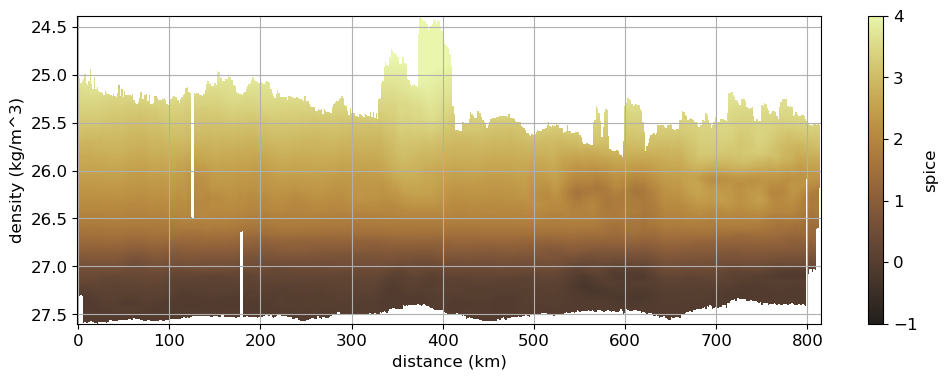

In [179]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_den.distance,ds_den.density,smoothed_spice,cmap=cmo.cm.turbid_r,vmin=-1,vmax=4)
#plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('density (kg/m^3)')
cbar = plt.colorbar()
cbar.set_label('spice')
#plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)


In [180]:
# Calculate N2
spicegrad = np.abs(np.diff(smoothed_spice, axis=1) / 1500)

zero_column = np.zeros((spicegrad.shape[0], 1))

spicegrad = np.hstack([spicegrad,zero_column])
spicegrad

array([[nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan,  0.]])

In [181]:
df = pd.DataFrame(spicegrad)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply a rolling mean along each row (distance axis)
window_size = 5

# Calculate the rolling mean with center=True
smoothed_df = df.rolling(window=window_size, min_periods=1, axis=1, center=True).mean()

# Create a smoothed array while keeping original NaNs in place
smoothed_grad = smoothed_df.where(~nan_mask, np.nan)

# Ensure the edges are handled correctly
for i in range(len(smoothed_grad)):
    # For the first point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_grad.iloc[i, 0]) and not nan_mask.iloc[i, 0]:
        smoothed_grad.iloc[i, 0] = df.iloc[i, :window_size].mean()

    # For the last point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_grad.iloc[i, -1]) and not nan_mask.iloc[i, -1]:
        smoothed_grad.iloc[i, -1] = df.iloc[i, -window_size:].mean()

# Ensure original NaNs are retained
smoothed_grad[nan_mask] = np.nan

spicegrad= smoothed_grad

In [182]:
spice = gsw.spiciness0(ds_den.salinity_filt, ds_den.temp_filt)
ds_den['spice'] = spice

df = pd.DataFrame(ds_den.spice)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply a rolling mean along each row (distance axis)
window_size = 15

# Calculate the rolling mean with center=True
smoothed_df = df.rolling(window=window_size, min_periods=1, axis=1, center=True).mean()

# Create a smoothed array while keeping original NaNs in place
smoothed_spice = smoothed_df.where(~nan_mask, np.nan)

# Ensure the edges are handled correctly
for i in range(len(smoothed_spice)):
    # For the first point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_spice.iloc[i, 0]) and not nan_mask.iloc[i, 0]:
        smoothed_spice.iloc[i, 0] = df.iloc[i, :window_size].mean()

    # For the last point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_spice.iloc[i, -1]) and not nan_mask.iloc[i, -1]:
        smoothed_spice.iloc[i, -1] = df.iloc[i, -window_size:].mean()

# Ensure original NaNs are retained
smoothed_spice[nan_mask] = np.nan

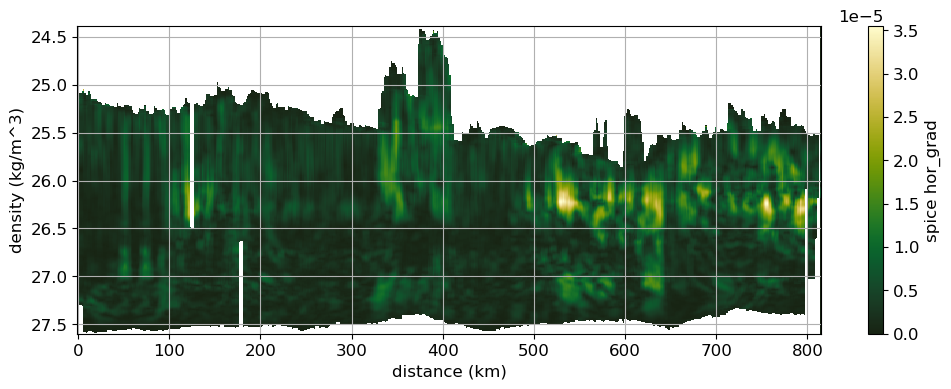

In [183]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_den.distance,ds_den.density, spicegrad,cmap=cmo.cm.speed_r)
#plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('density (kg/m^3)')
cbar = plt.colorbar()
cbar.set_label('spice hor_grad')

In [184]:
# Step 2: Calculate the deviation of temp_an from the smoothed temperature anomalies
anomaly_to_mean = ds_den.spice - smoothed_spice

# Step 3: Compute the standard deviation along each transect (distance)
anomaly_to_mean

<xarray.DataArray 'spice' (density: 1605, distance: 544)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * density   (density) float64 24.39 24.39 24.39 24.39 ... 27.59 27.59 27.6
  * distance  (distance) float64 0.0 1.5 3.0 4.5 6.0 ... 810.0 811.5 813.0 814.5

In [185]:
# Initialize an empty list to store the RMS values for each profile (2D array in density and distance)
RMS_2D = []

# Loop over each distance index
for distance_idx in range(anomaly_to_mean.distance.size):
    # Select the profile at the current distance, keeping density dimension intact
    spice_an_profile = anomaly_to_mean.isel(distance=distance_idx)
    
    # Calculate the squared anomaly for the current profile across density
    squared_anomaly_profile = spice_an_profile ** 2
    
    # Divide by the number of non-NaN values along the density axis
    N = np.sum(~np.isnan(squared_anomaly_profile), axis=0)  # Number of valid (non-NaN) data points per density
    RMS_profile = np.sqrt(squared_anomaly_profile )  # RMS along the density dimension
    
    # Append the result to RMS_2D
    RMS_2D.append(RMS_profile)

# Stack the list into a 2D array in density and distance dimensions
RMS_2D_array = xr.DataArray(
    RMS_2D, 
    coords=[ds_den.distance, ds_den.density], 
    dims=["distance", "density"]
).transpose("density", "distance")

RMS_2D_array

<xarray.DataArray (density: 1605, distance: 544)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * distance  (distance) float64 0.0 1.5 3.0 4.5 6.0 ... 810.0 811.5 813.0 814.5
  * density   (density) float64 24.39 24.39 24.39 24.39 ... 27.59 27.59 27.6

In [186]:
df = pd.DataFrame(RMS_2D_array)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply a rolling mean along each row (distance axis)
window_size = 5

# Calculate the rolling mean with center=True
smoothed_df = df.rolling(window=window_size, min_periods=1, axis=1, center=True).mean()

# Create a smoothed array while keeping original NaNs in place
smoothed_grad = smoothed_df.where(~nan_mask, np.nan)

# Ensure the edges are handled correctly
for i in range(len(smoothed_grad)):
    # For the first point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_grad.iloc[i, 0]) and not nan_mask.iloc[i, 0]:
        smoothed_grad.iloc[i, 0] = df.iloc[i, :window_size].mean()

    # For the last point, set to the mean of available points if it is not NaN in the original
    if pd.isna(smoothed_grad.iloc[i, -1]) and not nan_mask.iloc[i, -1]:
        smoothed_grad.iloc[i, -1] = df.iloc[i, -window_size:].mean()

# Ensure original NaNs are retained
smoothed_grad[nan_mask] = np.nan

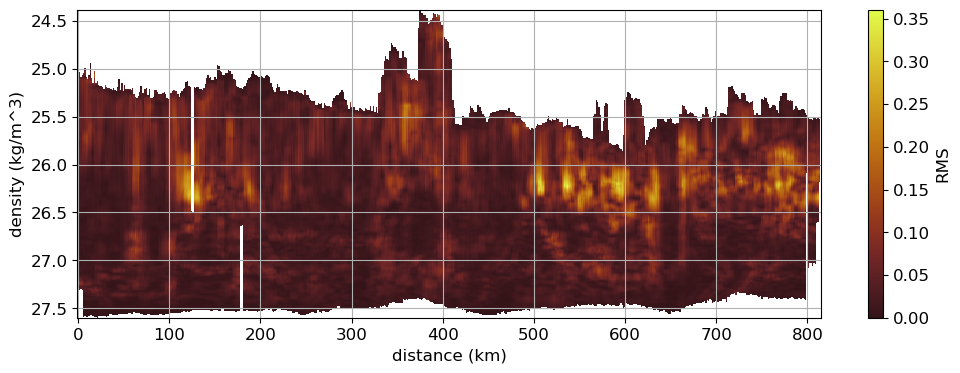

In [187]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_den.distance,ds_den.density,smoothed_grad,cmap=cmo.cm.solar)
#plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('density (kg/m^3)')
cbar = plt.colorbar()
cbar.set_label('RMS')

In [188]:
Mixing_Length = smoothed_grad/spicegrad
Mixing_Length

0    1    2    3    4    5    6    7    8    9    ...  534  535  536  \
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1600  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1601  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1602  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1603  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1604  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      537  538  539  540  541  542  543  
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...   ...  ...  ...  ...  ...  ...  ...  
1600  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1601  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1602  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1603  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1604  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1605 rows x 544 columns]

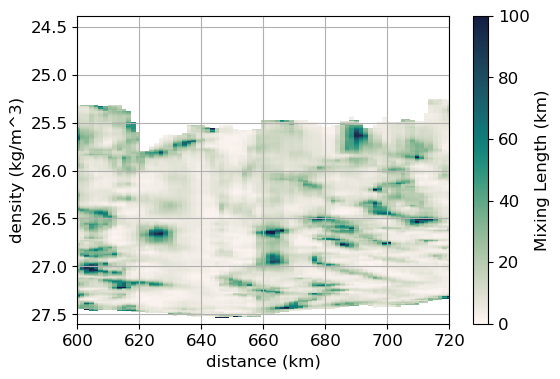

In [189]:
plt.figure(figsize=(6,4))
plt.pcolormesh(ds_den.distance,ds_den.density,Mixing_Length/1000,cmap=cmo.cm.tempo,vmin=0,vmax=100)
#plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlim(600,720)
plt.xlabel('distance (km)')
plt.ylabel('density (kg/m^3)')
cbar = plt.colorbar()
cbar.set_label('Mixing Length (km)')

In [190]:
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
ds_work['density'] = density

In [191]:
import numpy as np
from scipy.interpolate import griddata

# Extract grids
density_grid = ds_den["density"].data  # (density,)
Mixing_Length_array = ds_den["Mixing_Length"].data  # (density, distance)
density_original = ds_work["density"].data  # (ctd_depth, distance)
ctd_depth_grid = ds_work["ctd_depth"].data  # (ctd_depth,)

# Prepare output array
Mixing_Length_remapped = np.full_like(ds_work["temp"], np.nan)  # Same shape as ds_work

# Loop over each distance column
for i in range(len(ds_work["distance"])):
    valid_mask = ~np.isnan(density_grid) & ~np.isnan(Mixing_Length_array[:, i])
    
    if np.sum(valid_mask) > 2:  # Ensure there are enough valid points
        # Interpolate Mixing_Length from density → depth
        Mixing_Length_remapped[:, i] = griddata(
            density_grid[valid_mask],  # Known density values
            Mixing_Length_array[valid_mask, i],  # Known Mixing_Length values
            density_original[:, i],  # Target density at each depth
            method="linear",
            fill_value=np.nan
        )

# Add remapped Mixing_Length to ds_work
ds_work["Mixing_Length"] = (["ctd_depth", "distance"], Mixing_Length_remapped)


In [193]:
import xarray as xr
import numpy as np

# Ensure Mixing_Length is a NumPy array
Mixing_Length_array = Mixing_Length.to_numpy()  # Convert DataFrame to NumPy array

# Check if Mixing_Length contains only NaN values
if np.isnan(Mixing_Length_array).all():
    raise ValueError("Mixing_Length contains only NaN values. Cannot add it to the dataset.")

# Convert Mixing_Length to an xarray.DataArray
mixing_length_da = xr.DataArray(
    Mixing_Length_array,
    dims=["density", "distance"],  # Dimensions matching ds_den
    coords={
        "density": ds_den.density,  # Use ds_den's density coordinate
        "distance": ds_den.distance  # Use ds_den's distance coordinate
    },
    name="Mixing_Length"  # Name of the variable
)

# Add Mixing_Length to ds_den
ds_den["Mixing_Length"] = mixing_length_da

# Inspect the updated dataset
print(ds_den)


<xarray.Dataset>
Dimensions:         (density: 1605, distance: 544)
Coordinates:
  * density         (density) float64 24.39 24.39 24.39 ... 27.59 27.59 27.6
  * distance        (distance) float64 0.0 1.5 3.0 4.5 ... 811.5 813.0 814.5
Data variables:
    temp            (density, distance) float64 nan nan nan nan ... nan nan nan
    salinity        (density, distance) float64 nan nan nan nan ... nan nan nan
    o2              (density, distance) float64 nan nan nan nan ... nan nan nan
    sol             (density, distance) float64 nan nan nan nan ... nan nan nan
    spectral_slope  (density, distance) float64 nan nan nan nan ... nan nan nan
    POC             (density, distance) float64 nan nan nan nan ... nan nan nan
    chl             (density, distance) float64 nan nan nan nan ... nan nan nan
    AOU             (density, distance) float64 nan nan nan nan ... nan nan nan
    temp_filt       (density, distance) float64 nan nan nan nan ... nan nan nan
    salinity_filt   (density,

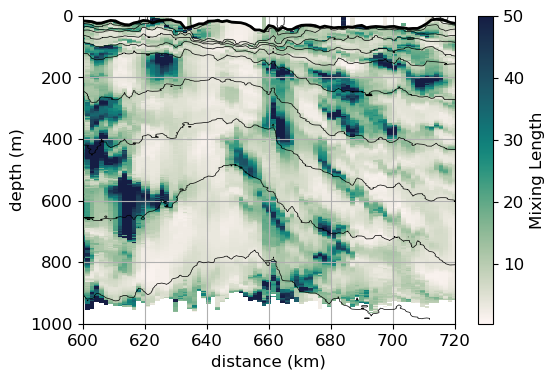

In [195]:
from scipy.interpolate import griddata
import numpy as np

# Ensure Mixing_Length is a 2D array
Mixing_Length_array = ds_den["Mixing_Length"].data

Mixing_Length_array = np.where(np.isinf(Mixing_Length_array), np.nan, Mixing_Length_array)


from scipy.ndimage import generic_filter

# Replace NaNs using nearest valid neighbor
Mixing_Length_array = generic_filter(Mixing_Length_array, np.nanmedian, size=3)


# Get the density and distance grid from ds_den
density_grid = ds_den["density"].data
distance_grid = ds_den["distance"].data

# Get the original density from ds_work
density_original = gsw.sigma0(ds_work["salinity"], ds_work["temp"]).data

# Create an empty array to store remapped Mixing_Length
Mixing_Length_remapped = np.full_like(ds_work["temp"], np.nan)  # Same shape as ds_work's variables

if density_grid.ndim == 1:
    density_grid = np.tile(density_grid[:, np.newaxis], (1, Mixing_Length_array.shape[1]))


# Loop through each distance point and interpolate back to depth
for i, dist in enumerate(ds_work["distance"]):
    if not np.isnan(density_original[:, i]).all():
        # Interpolate Mixing_Length from density grid to depth
        Mixing_Length_remapped[:, i] = griddata(
            density_grid[:, i].flatten(),  # Flattening ensures 1D input
            Mixing_Length_array[:, i].flatten(),  
            density_original[:, i],  
            method="nearest",
            fill_value=np.nan
        )


# Add remapped Mixing_Length to ds_work
ds_work["Mixing_Length"] = (["ctd_depth", "distance"], Mixing_Length_remapped)

# Inspect the updated dataset
ds_work

beginning = 25  # Beginning value
ending = 27.4    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

# Plot the smoothed data
plt.figure(figsize=(6, 4))
plt.pcolormesh(ML.distance, ML.ctd_depth, ML/1000,cmap=cmo.cm.tempo, vmax=50)
#plt.ylim(0,850)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Mixing Length')
plt.xlim(600,720)

plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add contours (optional)
plt.contour(density.distance, density.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#plt.title('after gaussian filter')

plt.show()

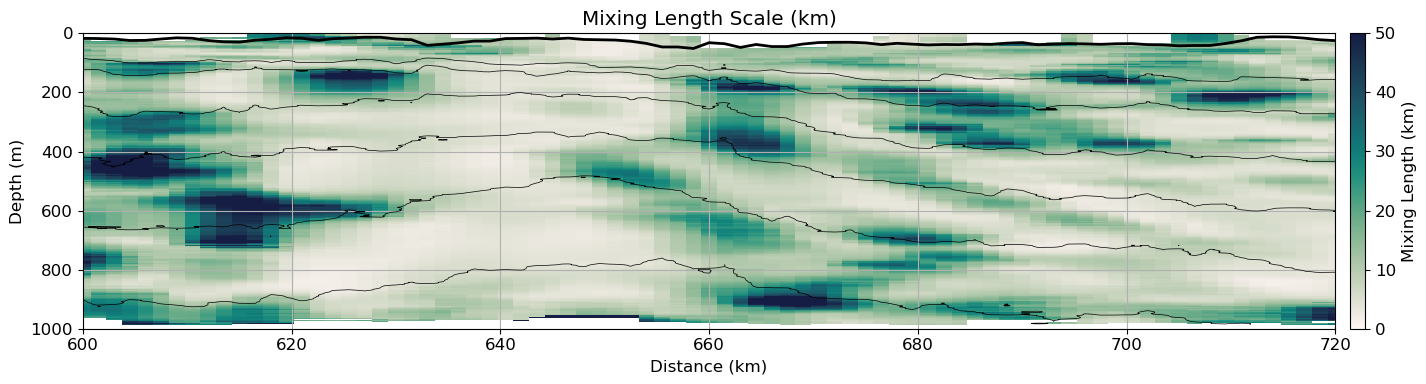

In [211]:
import matplotlib.pyplot as plt
import cmocean as cmo
import numpy as np




# Define a function for the 5-point running mean
def running_mean(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Extract and process the data for Mixing Length Scale
mixing_length_data = ds_work["Mixing_Length"].data / 1000  # Convert Mixing Length to km

# Apply 5-point running mean smoothing along the distance dimension
smoothed_mixing_length = np.apply_along_axis(running_mean, axis=1, arr=mixing_length_data)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 4))

# Plot the smoothed Mixing Length Scale
cmesh = ax.pcolormesh(
    ds_work.distance,
    ds_work.ctd_depth,
    smoothed_mixing_length,
    cmap=cmo.cm.tempo,
    vmin=0,
    vmax=50
)

# Add the mixed layer density line
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add density contours
ax.contour(
    density.distance,
    density.ctd_depth,
    density,
    levels=np.arange(26.4, 27.8, 0.2),  # Example levels
    colors='k',
    linewidths=0.5
)

# Customize plot
#ax.set_ylim(0, 1000)
ax.invert_yaxis()  # Invert depth axis
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')
ax.set_title('Mixing Length Scale (km)')
ax.grid(True)
ax.set_xlim(600, 720)

# Add colorbar
cbar = plt.colorbar(cmesh, ax=ax, pad=0.01)
cbar.set_label("Mixing Length (km)")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# spice and spiciness curvature 

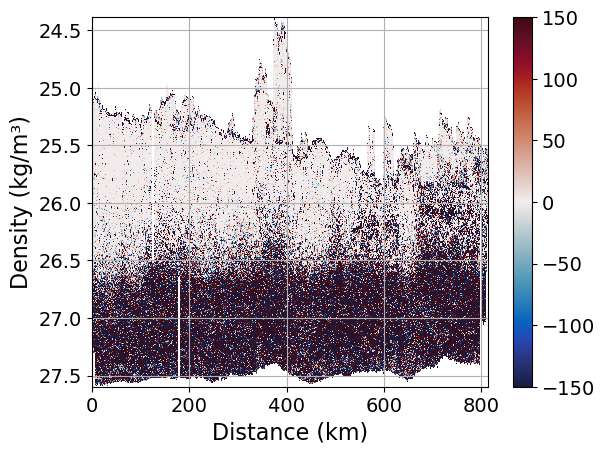

In [351]:
spice = spice = gsw.spiciness0(ds_den.salinity, ds_den.temp)

first_da = (np.diff(spice, axis=0)/-0.002)

zero_row = np.zeros((1, first_da.shape[1])) 

# Concatenate the zero row to the top of N2
first_da = np.vstack([zero_row, first_da])

second_da = (np.diff(first_da, axis=0)/-0.002)

zero_row = np.zeros((1, second_da.shape[1])) 

# Concatenate the zero row to the top of N2
second_da = np.vstack([zero_row, second_da])

plt.pcolormesh(ds_den.distance, ds_den.density, second_da, cmap = cmo.cm.balance,vmin= -150, vmax = 150)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.gca().invert_yaxis()
plt.grid()
cbar = plt.colorbar()

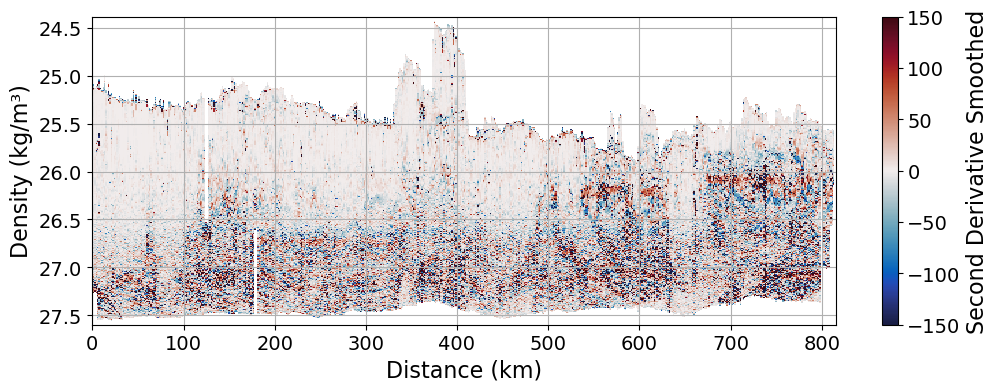

In [158]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from scipy.ndimage import uniform_filter1d  # Alternative for rolling mean smoothing

  # Calculate the density interval
window_size = 41  # Number of points corresponding to 8 kg/m³

# Create the second_da DataArray for smoothing, assuming it is aligned with ds_den coordinates
second_da_xr = xr.DataArray(
    second_da,
    coords={'density': ds_den.density, 'distance': ds_den.distance},
    dims=['density', 'distance']
)

# Apply rolling mean or smoothing over the 'density' axis
smoothed_second_da = second_da_xr.rolling(density=window_size, center=True).mean()

# Optionally, if NaNs need to be handled, fill or interpolate as necessary
#smoothed_second_da = smoothed_second_da.fillna(0)  # or use interpolation if preferred


plt.figure(figsize=(12,4))
# Plot the smoothed data
plt.pcolormesh(ds_den.distance, ds_den.density, smoothed_second_da, cmap=cmo.balance, vmin=-150, vmax=150)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.gca().invert_yaxis()
plt.grid()
cbar = plt.colorbar()
cbar.set_label('Second Derivative Smoothed')
plt.show()


In [30]:
import numpy as np
from scipy.signal import convolve

# Parameters
window_size = 41  # Window size (odd number)
blackman_window = np.blackman(window_size)  # Blackman window

# Normalize the Blackman window
blackman_window /= blackman_window.sum()

ds_den['temp_filt'] = (('density', 'distance'), np.zeros_like(ds_den['temp'])) 
ds_den['salinity_filt'] = (('density', 'distance'), np.zeros_like(ds_den['salinity'])) 

# Filtering CT
for i in range(ds_den['temp'].shape[1]):
    ds_den['temp_filt'][:, i] = convolve(ds_den['temp'][:, i], blackman_window, mode='same')

# Filtering SA
for i in range(ds_den['salinity'].shape[1]):
    ds_den['salinity_filt'][:, i] = convolve(ds_den['salinity'][:, i], blackman_window, mode='same')

In [31]:
spice = gsw.spiciness0(ds_den.salinity_filt, ds_den.temp_filt)
ds_den['spice'] = spice

In [290]:
# Define as DataArray with explicit dimensions
second_da_smoothed_xr = xr.DataArray(
    second_da_smoothed,
    coords={'density': ds_den.density, 'distance': ds_den.distance},
    dims=['density', 'distance']
)

# Assign smoothed data to `ds_den`
ds_den['spice_curv'] = second_da_smoothed_xr

spice shape: (1605, 544)
spice_curv shape: (1605, 544)
spectral_slope shape: (1605, 544)
AOU shape: (1605, 544)
Processing spice...
Reshaped density_grid to 2D: (1605, 544)
Expanded depth_grid to 2D: (2001, 544)
Processing spice_curv...
Reshaped density_grid to 2D: (1605, 544)
Expanded depth_grid to 2D: (2001, 544)
Processing spectral_slope...
Reshaped density_grid to 2D: (1605, 544)
Expanded depth_grid to 2D: (2001, 544)
Processing AOU...
Reshaped density_grid to 2D: (1605, 544)
Expanded depth_grid to 2D: (2001, 544)


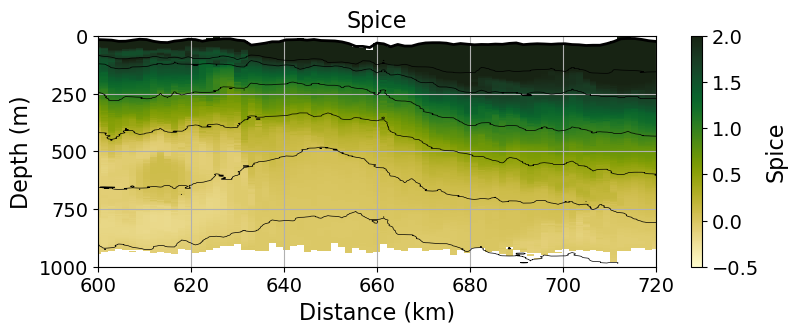

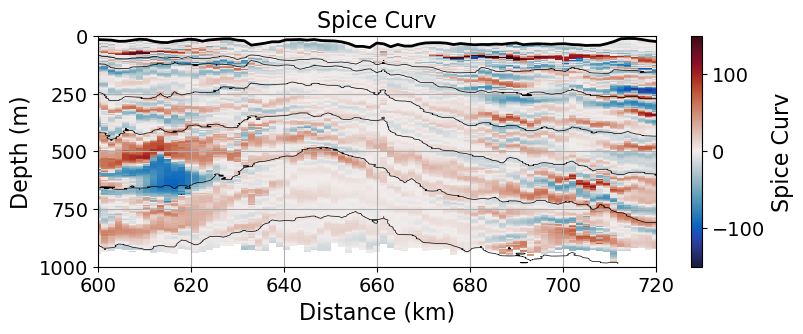

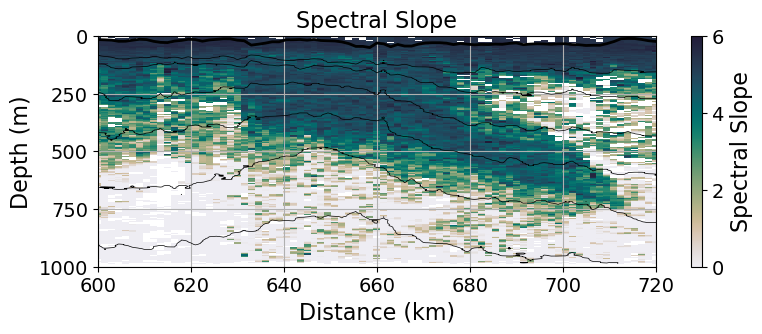

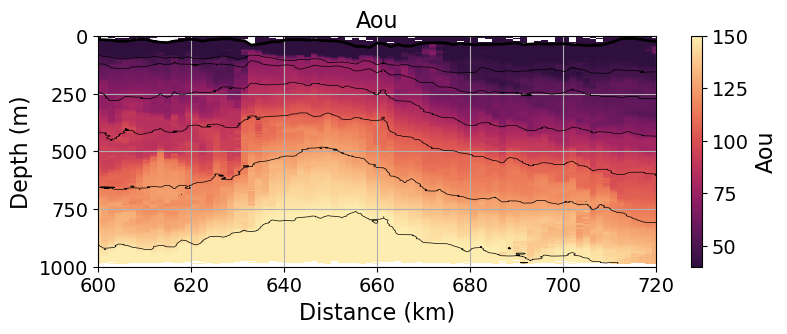

In [164]:
from scipy.interpolate import griddata

variables = ["spice", "spice_curv", "spectral_slope", "AOU"]
for var in variables:
    if var not in ds_den.data_vars:
        raise ValueError(f"Variable '{var}' not found in ds_den.")
    var_density_space = ds_den[var].data
    print(f"{var} shape:", np.shape(var_density_space))

depth_grid = ds_work["ctd_depth"].data 

def remap_to_depth(var_density_space, density_grid, depth_grid, density_original):
    # Ensure density_grid is 2D
    if len(density_grid.shape) == 1:
        density_grid = np.tile(density_grid[:, None], (1, var_density_space.shape[1]))
        print("Reshaped density_grid to 2D:", density_grid.shape)

    # Ensure depth_grid matches density_original
    if depth_grid.shape != density_original.shape:
        if len(depth_grid.shape) == 1:  # If 1D, expand to 2D
            depth_grid = np.tile(depth_grid[:, None], (1, density_original.shape[1]))
            print("Expanded depth_grid to 2D:", depth_grid.shape)
        else:
            raise ValueError("Depth grid shape is incompatible with density_original.")

    # Ensure shapes match
    assert density_grid.shape == var_density_space.shape, "Density and variable mismatch in shape!"
    assert depth_grid.shape == density_original.shape, "Depth grid and density_original mismatch!"

    # Create an empty array for the remapped variable
    remapped_var = np.full_like(density_original, np.nan)

    # Loop through each distance point
    for i in range(density_original.shape[1]):  # Iterate over columns (distance points)
        if not np.isnan(density_original[:, i]).all():
            remapped_var[:, i] = griddata(
                density_grid[:, i],          # Density grid for this distance point
                var_density_space[:, i],     # Corresponding variable values
                density_original[:, i],      # Target densities at each depth
                method="linear",
                fill_value=np.nan,
            )
    return remapped_var


variables = ["spice", "spice_curv", "spectral_slope", "AOU"]

for var in variables:
    print(f"Processing {var}...")
    var_density_space = ds_den[var].data
    remapped_var = remap_to_depth(
        var_density_space,
        density_grid,
        ds_work.ctd_depth.data,
        density_original,
    )
    ds_work[var] = (["depth", "distance"], remapped_var)
    
# Plot remapped variables
cmap_dict = {
    "spice": cmo.speed,
    "spice_curv": cmo.balance,
    "spectral_slope": cmo.rain,
    "AOU": cmo.matter_r,
}
vmin_dict = {"spice": -0.5, "spice_curv": -150, "spectral_slope": 0, "AOU": 40}
vmax_dict = {"spice": 2, "spice_curv": 150, "spectral_slope": 6, "AOU": 150}

for var in variables:
    plt.figure(figsize=(9, 3))
    plt.pcolormesh(
        ds_work.distance,
        ds_work.ctd_depth,
        ds_work[var].data,
        cmap=cmap_dict[var],
        vmin=vmin_dict[var],
        vmax=vmax_dict[var],
    )
    plt.xlabel('Distance (km)')
    plt.ylabel('Depth (m)')
    plt.title(var.replace('_', ' ').title())
    plt.gca().invert_yaxis()
    plt.grid(True)
    cbar = plt.colorbar()
    cbar.set_label(var.replace('_', ' ').title())
    plt.xlim(600, 720)
    
    plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

    # Add contours (optional)
    plt.contour(density.distance, density.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
    plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_4444\4082553781.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


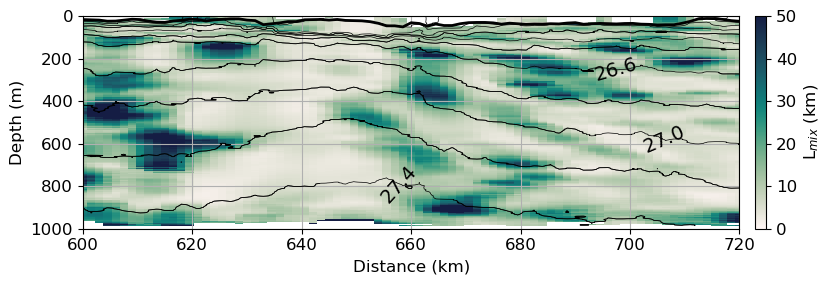

In [223]:
import matplotlib.pyplot as plt
import cmocean as cmo
import numpy as np

# Define a function for the 5-point running mean
def running_mean(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Extract and process the data for Mixing Length Scale
mixing_length_data = ds_work["Mixing_Length"].data / 1000  # Convert Mixing Length to km

# Apply 5-point running mean smoothing along the distance dimension
smoothed_mixing_length = np.apply_along_axis(running_mean, axis=1, arr=mixing_length_data)

# Create the plot
fig, ax = plt.subplots(figsize=(9, 3))

# Plot the smoothed Mixing Length Scale
cmesh = ax.pcolormesh(
    ds_work.distance,
    ds_work.ctd_depth,
    smoothed_mixing_length,
    cmap=cmo.cm.tempo,
    vmin=0,
    vmax=50
)

# Add the mixed layer density line
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)



levels = np.arange(26, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(26.6, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax.clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

# Add density contours
ax.contour(
    density.distance,
    density.ctd_depth,
    density,
    levels=np.arange(25, 28, 0.2),  # Example levels
    colors='k',
    linewidths=0.5
)

# Customize plot
#ax.set_ylim(0, 800)
ax.invert_yaxis()  # Invert depth axis
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')

ax.grid(True)
ax.set_xlim(600, 720)

# Add colorbar
cbar = plt.colorbar(cmesh, ax=ax, pad = 0.02)
cbar.set_label("L$_{mix}$ (km)")

# Adjust layout and show the plot
plt.tight_layout()

plt.savefig('Mixing_length.png', bbox_inches='tight', dpi=100)
plt.show()


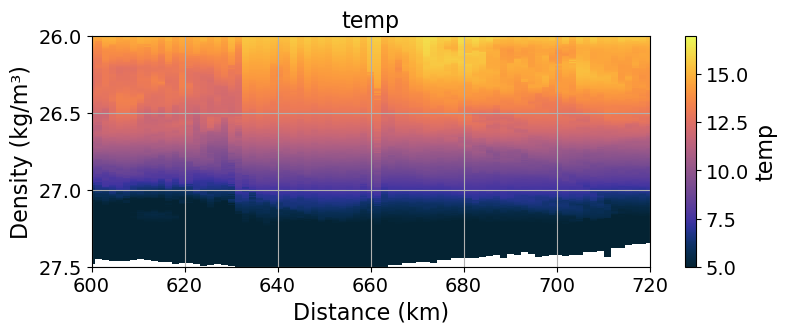

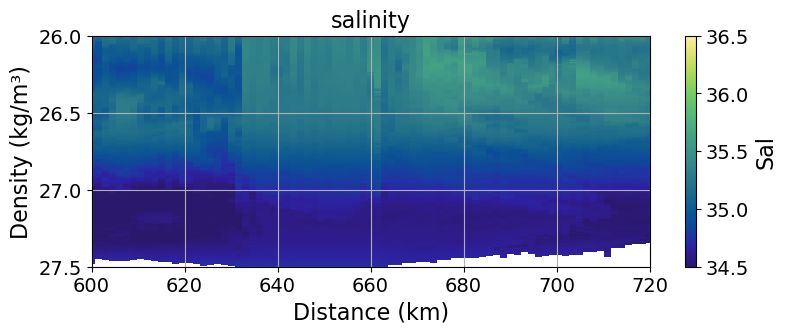

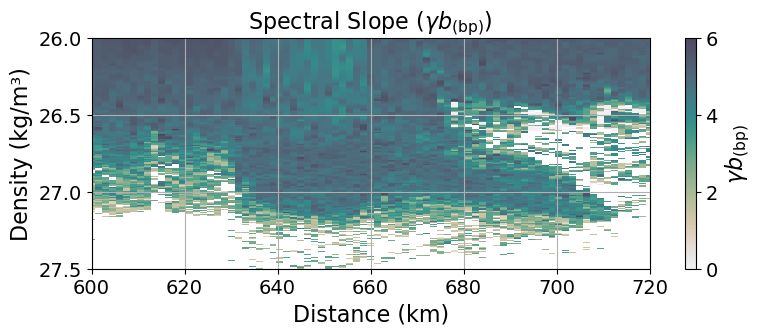

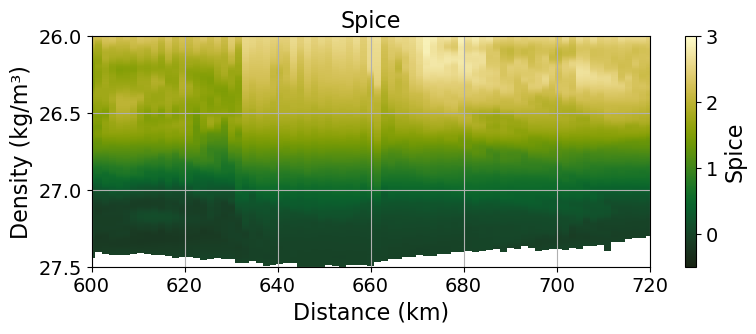

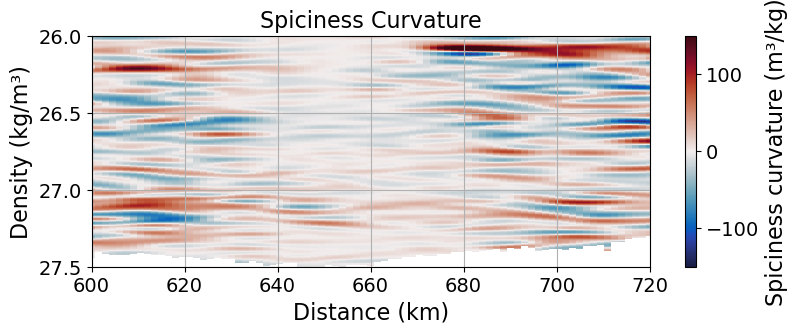

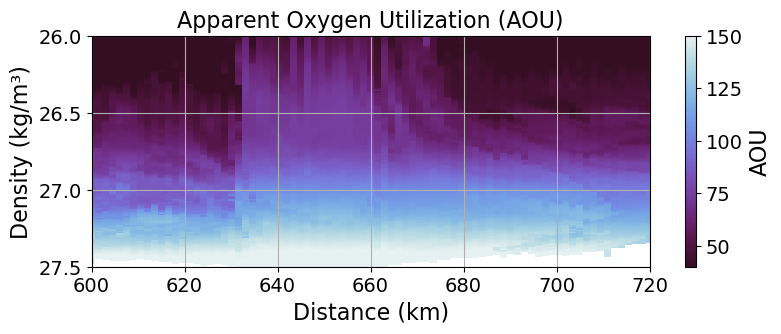

In [327]:
import matplotlib.pyplot as plt
import cmocean as cmo  # Assuming you're using cmocean for colormaps


plt.figure(figsize=(9, 3))
plt.pcolormesh(ds_den.distance, ds_den.density, ds_den['temp'], cmap=cmo.cm.thermal, vmin=5, vmax=17)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('temp')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('temp')
plt.show()

plt.figure(figsize=(9, 3))
plt.pcolormesh(ds_den.distance, ds_den.density, ds_den['salinity'], cmap=cmo.cm.haline, vmin=34.5, vmax=36.5)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('salinity')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Sal')
plt.show()

plt.figure(figsize=(9,3))
plt.pcolormesh(ds_den.distance, ds_den.density, ds_den.spectral_slope, vmin=0, vmax=6, cmap=cmo.cm.rain, alpha=0.8)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('Spectral Slope ($\gamma$$b_{\mathrm{(bp)}}$)')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label(r'$\gamma$$b_{\mathrm{(bp)}}$')
plt.show()

plt.figure(figsize=(9, 3))
plt.pcolormesh(ds_den.distance, ds_den.density, ds_den['spice'], cmap=cmo.cm.speed_r, vmin=-0.5, vmax=3)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('Spice')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Spice')
plt.show()

plt.figure(figsize=(9, 3))
plt.pcolormesh(ds_den.distance, ds_den.density, second_da_smoothed, cmap=cmo.cm.balance, vmin=-150, vmax=150)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('Spiciness Curvature')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('Spiciness curvature (m³/kg)')
plt.show()





plt.figure(figsize=(9, 3))
plt.pcolormesh(ds_den.distance, ds_den.density, ds_den['AOU'], cmap=cmo.cm.dense_r, vmin=40, vmax=150)
plt.xlabel('Distance (km)')
plt.ylabel('Density (kg/m³)')
plt.title('Apparent Oxygen Utilization (AOU)')
plt.xlim(600, 720)
plt.ylim(26,27.5)
plt.gca().invert_yaxis()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label('AOU')
plt.show()



# combined figure

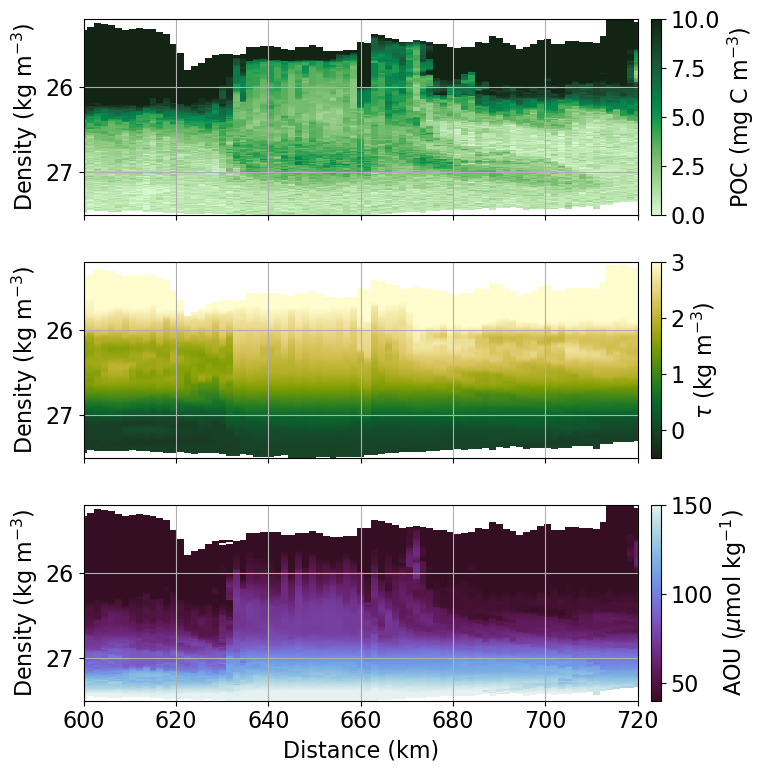

In [32]:
import matplotlib.pyplot as plt
import cmocean as cmo  # Assuming you're using cmocean for colormaps

# Create a figure with 3 rows and 1 column of subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=True)

# Plot Spectral Slope
p1 = axs[0].pcolormesh(
    ds_den.distance, ds_den.density, ds_den.POC,
    vmin=0, vmax=10, cmap=cmo.cm.algae
)
axs[0].set_ylabel('Density (kg m$^{-3}$)')
axs[0].invert_yaxis()
axs[0].grid(True)
cbar1 = fig.colorbar(p1, ax=axs[0], orientation='vertical', pad=0.02)
cbar1.set_label(r'POC (mg C m$^{-3}$)')

# Plot Spice
p2 = axs[1].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['spice'],
    cmap=cmo.cm.speed_r, vmin=-0.5, vmax=3
)
axs[1].set_ylabel('Density (kg m$^{-3}$)')
axs[1].invert_yaxis()
axs[1].grid(True)
cbar2 = fig.colorbar(p2, ax=axs[1], orientation='vertical', pad=0.02)
cbar2.set_label(r'$\tau$ (kg m$^{-3}$)')

# Plot AOU
p3 = axs[2].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['AOU'],
    cmap=cmo.cm.dense_r, vmin=40, vmax=150
)
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('Density (kg m$^{-3}$)')
axs[2].grid(True)
cbar3 = fig.colorbar(p3, ax=axs[2], orientation='vertical', pad=0.02)
cbar3.set_label('AOU ($\mu$mol kg$^{-1}$)')

plt.xlim(600, 720)
plt.ylim(25.2,27.5)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
# Adjust layout for better readability
plt.tight_layout()

plt.plot(mixed_layer_densities)

plt.savefig('density.png', bbox_inches='tight', dpi=100)
plt.show()


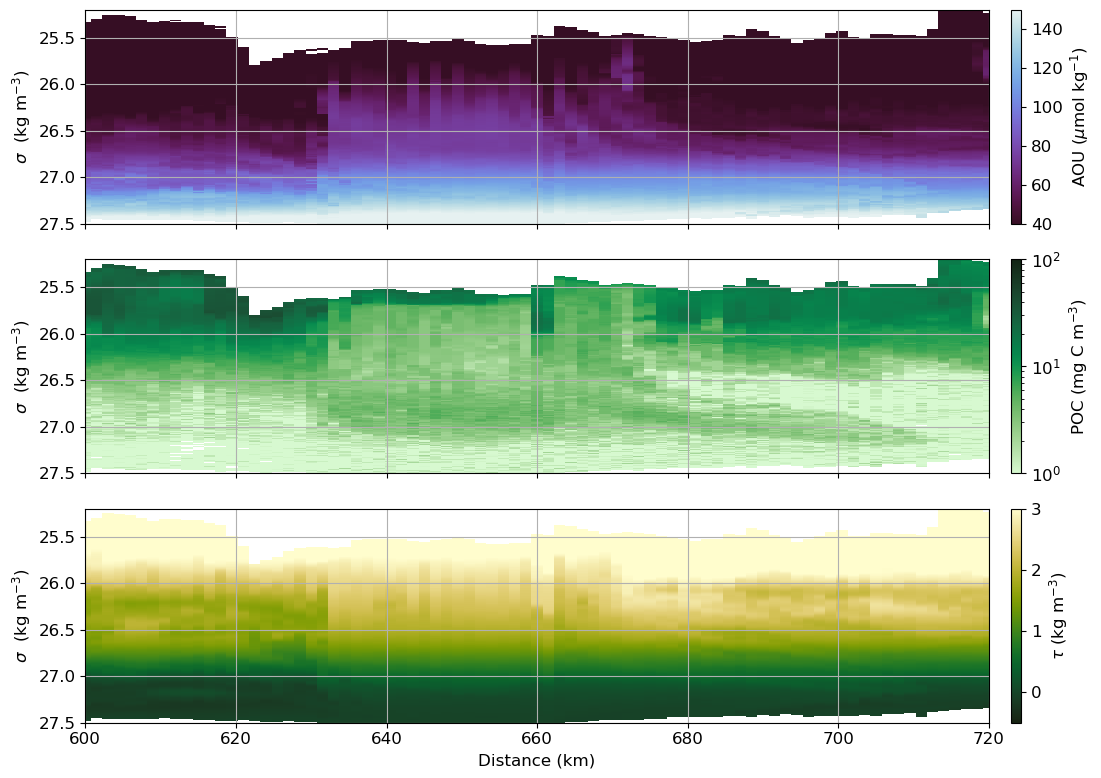

In [227]:
import matplotlib.pyplot as plt
import cmocean as cmo  # Assuming you're using cmocean for colormaps

# Create a figure with 3 rows and 1 column of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)

# Plot AOU (was last, now first)
p1 = axs[0].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['AOU'],
    cmap=cmo.cm.dense_r, vmin=40, vmax=150
)
axs[0].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[0].invert_yaxis()
axs[0].grid(True)
cbar1 = fig.colorbar(p1, ax=axs[0], orientation='vertical', pad=0.02)
cbar1.set_label('AOU ($\mu$mol kg$^{-1}$)')

# Plot POC (was first, now second)
p2 = axs[1].pcolormesh(
    ds_den.distance, ds_den.density, ds_den.POC, cmap=cmo.cm.algae, norm=LogNorm(vmin=1, vmax=100)
)
axs[1].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[1].invert_yaxis()
axs[1].grid(True)
cbar2 = fig.colorbar(p2, ax=axs[1], orientation='vertical', pad=0.02)
cbar2.set_label(r'POC (mg C m$^{-3}$)')



# Plot Spice (was second, now last)
p3 = axs[2].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['spice'],
    cmap=cmo.cm.speed_r, vmin=-0.5, vmax=3
)
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[2].invert_yaxis()
axs[2].grid(True)
cbar3 = fig.colorbar(p3, ax=axs[2], orientation='vertical', pad=0.02)
cbar3.set_label(r'$\tau$ (kg m$^{-3}$)')

# Set axis limits
plt.xlim(600, 720)
plt.ylim(25.2, 27.5)

# Ensure all subplots have inverted y-axis
for ax in axs:
    ax.invert_yaxis()

# Adjust layout for better readability
plt.tight_layout()

plt.plot(mixed_layer_densities)

plt.savefig('density.png', bbox_inches='tight', dpi=100)
plt.show()


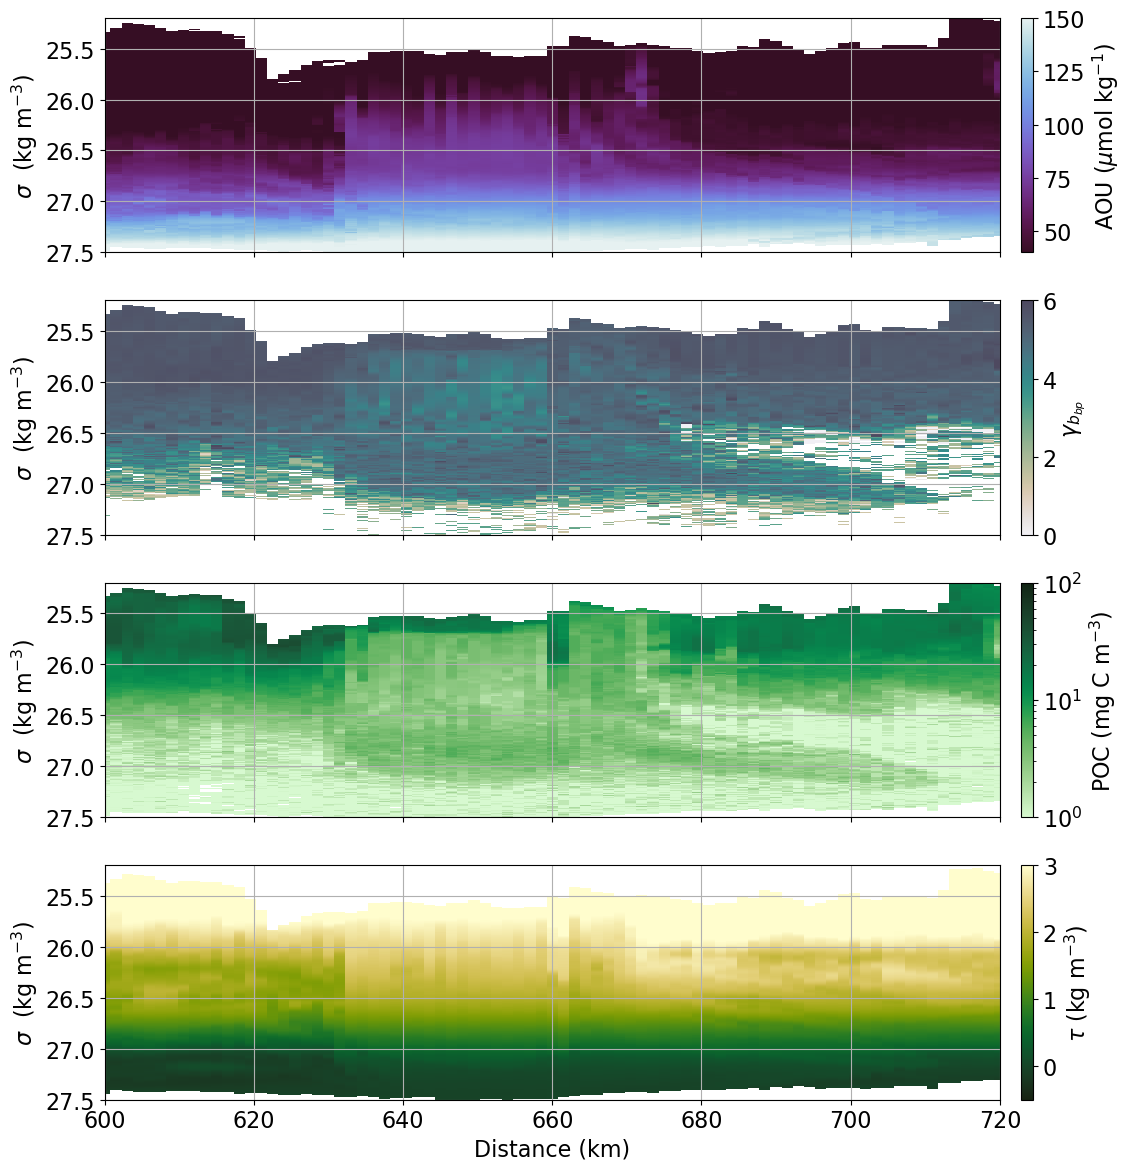

In [56]:
import matplotlib.pyplot as plt
import cmocean as cmo  # Assuming you're using cmocean for colormaps
from matplotlib.colors import LogNorm

# Create a figure with 4 rows and 1 column of subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)

# Plot AOU (first panel)
p1 = axs[0].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['AOU'],
    cmap=cmo.cm.dense_r, vmin=40, vmax=150
)
axs[0].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[0].grid(True)
cbar1 = fig.colorbar(p1, ax=axs[0], orientation='vertical', pad=0.02)
cbar1.set_label('AOU ($\mu$mol kg$^{-1}$)')



# Plot Spectral Slope (third panel, new)
p2 = axs[1].pcolormesh(
    ds_den.distance, ds_den.density, ds_den.spectral_slope, 
    cmap=cmo.cm.rain, vmin=0, vmax=6, alpha=0.8
)
axs[1].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[1].grid(True)
cbar2 = fig.colorbar(p2, ax=axs[1], orientation='vertical', pad=0.02)
cbar2.set_label(r'$\gamma_{b_{bp}}$')

# Plot POC (second panel)
p3 = axs[2].pcolormesh(
    ds_den.distance, ds_den.density, ds_den.POC, 
    cmap=cmo.cm.algae, norm=LogNorm(vmin=1, vmax=100)
)
axs[2].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[2].grid(True)
cbar3 = fig.colorbar(p3, ax=axs[2], orientation='vertical', pad=0.02)
cbar3.set_label(r'POC (mg C m$^{-3}$)')

# Plot Spice (fourth panel)
p4 = axs[3].pcolormesh(
    ds_den.distance, ds_den.density, ds_den['spice'],
    cmap=cmo.cm.speed_r, vmin=-0.5, vmax=3
)
axs[3].set_xlabel('Distance (km)')
axs[3].set_ylabel('$\sigma$  (kg m$^{-3}$)')
axs[3].grid(True)
cbar4 = fig.colorbar(p4, ax=axs[3], orientation='vertical', pad=0.02)
cbar4.set_label(r'$\tau$ (kg m$^{-3}$)')

# Set x and y axis limits
plt.xlim(600, 720)
plt.ylim(27.5, 25.2)  # Explicitly reverse the limits

# Ensure all subplots have an inverted y-axis
for ax in axs:
    ax.invert_yaxis()  # Explicitly apply inversion

# Adjust layout for better readability
plt.tight_layout()

plt.savefig('density.png', bbox_inches='tight', dpi=100)
plt.show()
